In [12]:
library(dplyr)
library(ggplot2)
library(repr)
library(stats)
library(caret)

In [28]:
# --- Setup -------------------------------------------------------------------
# install.packages("Stat2Data") # uncomment if you don't have it
library(Stat2Data)

# load dataset (name as provided by package)
data("LostLetter", package="Stat2Data")
LL <- LostLetter

# quick peek
str(LL)
head(LL)

# If the dataset contains aggregated counts (e.g. Returned and NotReturned),
# the code below will adapt. If it's one row per letter with Returned in {0,1},
# the code will also work.
# Create an aggregated table by Location x Address:
tab <- with(LL, table(Location, Address))
cat("Counts per cell (Location x Address):\n")
print(tab)

# If LL has per-letter rows:
#   Returned should be 0/1 (or logical). If it contains counts instead,
#   the following aggregate will attempt to detect that.
if (any(LL$Returned > 1)) {
  message("Detected counts in Returned column; assuming Returned is number returned per cell.")
  # assume LL contains variables: Returned, Total (or try to compute Total)
  # Try to find a 'Total' or 'N' column; if none, attempt to aggregate from dataset
  if ("Total" %in% names(LL)) {
    agg <- aggregate(cbind(returned = Returned, total = Total) ~ Location + Address, data = LL, sum)
  } else if ("n" %in% names(LL)) {
    agg <- aggregate(cbind(returned = Returned, total = n) ~ Location + Address, data = LL, sum)
  } else {
    # if no explicit total, try to set total = Returned (not ideal) -> user should confirm
    stop("Dataset appears to have counts in 'Returned' but no 'Total'/'n' column found. Please provide totals.")
  }
  agg$notReturned <- agg$total - agg$returned
  # models below will use 'agg' and cbind(returned, notReturned)
  use_agg <- TRUE
} else {
  # per-letter rows with Returned = 0/1
  use_agg <- FALSE
}

'data.frame':	140 obs. of  8 variables:
 $ Location     : Factor w/ 3 levels "DesMoines","GrinnellCampus",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Address      : Factor w/ 2 levels "Confederacy",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Returned     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DesMoines    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ GrinnellTown : int  0 0 0 0 0 0 0 0 0 0 ...
 $ GrinellCampus: int  0 0 0 0 0 0 0 0 0 0 ...
 $ Peaceworks   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Confederacy  : int  0 0 0 0 0 0 0 0 0 0 ...


,Location,Address,Returned,DesMoines,GrinnellTown,GrinellCampus,Peaceworks,Confederacy
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,DesMoines,Peaceworks,1,1,0,0,1,0
2,DesMoines,Peaceworks,1,1,0,0,1,0
3,DesMoines,Peaceworks,1,1,0,0,1,0
4,DesMoines,Peaceworks,1,1,0,0,1,0
5,DesMoines,Peaceworks,1,1,0,0,1,0
6,DesMoines,Peaceworks,1,1,0,0,1,0


Counts per cell (Location x Address):
                Address
Location         Confederacy Peaceworks
  DesMoines               40         40
  GrinnellCampus          10         10
  GrinnellTown            20         20


In [29]:
# ----------------- Fit primary logistic model --------------------------------
# Model: Returned ~ Location + Address
if (!use_agg) {
  m1 <- glm(Returned ~ Location + Address, data = LL, family = binomial)
} else {
  m1 <- glm(cbind(returned, notReturned) ~ Location + Address, data = agg, family = binomial)
}

summary(m1)

# Odds ratios and 95% CIs
coefs <- coef(m1)
OR <- exp(coefs)
ci <- confint.default(m1)           # Wald CIs
ORci <- exp(ci)
cat("\nOdds ratios (exp(coef)) and 95% Wald CIs:\n")
print(cbind(OR, ORci))


Call:
glm(formula = Returned ~ Location + Address, family = binomial, 
    data = LL)

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.4243     0.2995  -1.417 0.156571    
LocationGrinnellCampus  -1.5089     0.5965  -2.530 0.011417 *  
LocationGrinnellTown     1.2520     0.4786   2.616 0.008897 ** 
AddressPeaceworks        1.4166     0.3983   3.557 0.000376 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 189.95  on 139  degrees of freedom
Residual deviance: 158.40  on 136  degrees of freedom
AIC: 166.4

Number of Fisher Scoring iterations: 4



Odds ratios (exp(coef)) and 95% Wald CIs:
                              OR      2.5 %    97.5 %
(Intercept)            0.6541968 0.36370252 1.1767128
LocationGrinnellCampus 0.2211424 0.06869616 0.7118877
LocationGrinnellTown   3.4972390 1.36883805 8.9350822
AddressPeaceworks      4.1228758 1.88876883 8.9995686


In [30]:
# ----------------- Goodness of fit (residual deviance) -----------------------
resDev <- deviance(m1)
dfRes  <- df.residual(m1)
p_chisq <- 1 - pchisq(resDev, dfRes)
cat("\nResidual deviance:", round(resDev,3), " on", dfRes, "df\n")
cat("Goodness-of-fit p-value (Chi-square):", format.pval(p_chisq), "\n")
# Interpretation: small p-value => lack of fit.


Residual deviance: 158.404  on 136 df
Goodness-of-fit p-value (Chi-square): 0.091726 


In [31]:
# --- Fit saturated model ---
if (!use_agg) {
  msat <- glm(Returned ~ Location * Address, data = LL, family = binomial)
} else {
  msat <- glm(cbind(returned, notReturned) ~ Location * Address, data = agg, family = binomial)
}
summary(msat)

# --- Extract empirical and model proportions ---
if (!use_agg) {
  # Aggregate success counts and totals
  agg_obs <- aggregate(Returned ~ Location + Address, data = LL,
                       FUN = function(x) c(success = sum(x), total = length(x)))

  # Expand the matrix-column into separate columns safely
  df_obs <- data.frame(
    Location = agg_obs$Location,
    Address = agg_obs$Address,
    returned = agg_obs$Returned[, "success"],
    total = agg_obs$Returned[, "total"]
  )

  # Empirical proportions
  df_obs$prop_empirical <- df_obs$returned / df_obs$total

  # Predicted proportions from both models
  df_obs$prop_model_m1  <- predict(m1, newdata = df_obs, type = "response")
  df_obs$prop_model_sat <- predict(msat, newdata = df_obs, type = "response")

} else {
  df_obs <- agg
  df_obs$prop_empirical <- df_obs$returned / df_obs$total
  df_obs$prop_model_m1  <- predict(m1, newdata = df_obs, type = "response")
  df_obs$prop_model_sat <- predict(msat, newdata = df_obs, type = "response")
}

# --- Print results ---
cat("\nEmpirical proportions and model probs (per cell):\n")
print(df_obs[, c("Location", "Address", "returned", "total",
                 "prop_empirical", "prop_model_m1", "prop_model_sat")])



Call:
glm(formula = Returned ~ Location * Address, family = binomial, 
    data = LL)

Coefficients:
                                         Estimate Std. Error z value Pr(>|z|)  
(Intercept)                               -0.3023     0.3198  -0.945   0.3446  
LocationGrinnellCampus                    -1.8949     1.1016  -1.720   0.0854 .
LocationGrinnellTown                       0.9213     0.5675   1.623   0.1045  
AddressPeaceworks                          1.1496     0.4705   2.443   0.0145 *
LocationGrinnellCampus:AddressPeaceworks   0.6422     1.3225   0.486   0.6273  
LocationGrinnellTown:AddressPeaceworks     1.1758     1.2222   0.962   0.3360  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 189.95  on 139  degrees of freedom
Residual deviance: 157.22  on 134  degrees of freedom
AIC: 169.22

Number of Fisher Scoring iterations: 5



Empirical proportions and model probs (per cell):
        Location     Address returned total prop_empirical prop_model_m1
1      DesMoines Confederacy       17    40          0.425     0.3954770
2 GrinnellCampus Confederacy        1    10          0.100     0.1263863
3   GrinnellTown Confederacy       13    20          0.650     0.6958529
4      DesMoines  Peaceworks       28    40          0.700     0.7295230
5 GrinnellCampus  Peaceworks        4    10          0.400     0.3736137
6   GrinnellTown  Peaceworks       19    20          0.950     0.9041471
  prop_model_sat
1          0.425
2          0.100
3          0.650
4          0.700
5          0.400
6          0.950



Differences (empirical - model) summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02639 0.02717 0.02952 0.03392 0.04177 0.04585 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1113  0.1278  0.1767  0.2585  0.2501  0.7003 


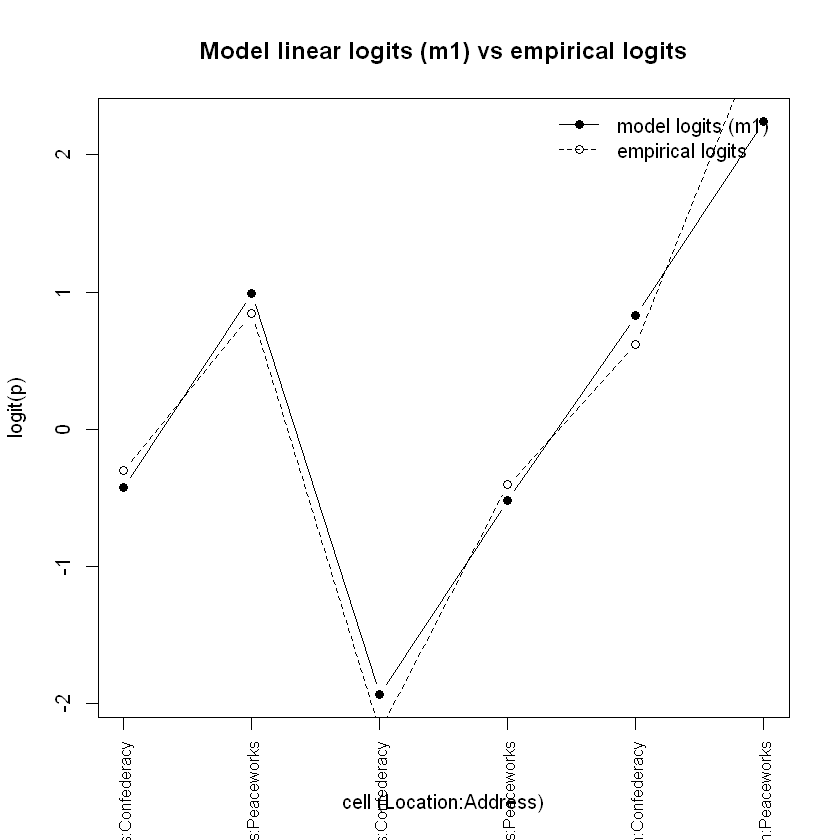

In [21]:
# ----------------- Compare empirical vs estimated logits & plot ----------------
# compute logits: log(p/(1-p))
logit <- function(p) log(p/(1-p))
df_obs$logit_empirical <- logit(df_obs$prop_empirical)
df_obs$logit_model     <- logit(df_obs$prop_model_m1)

# Basic plot: empirical logits vs model logits (same plot by cell)
# Order rows for plotting aesthetic
df_obs$cell <- paste(df_obs$Location, df_obs$Address, sep=":")
ord <- order(df_obs$Location, df_obs$Address)
df_obs <- df_obs[ord, ]

# Plot (you can tweak labels)
plot(df_obs$logit_model, type="b", pch=16, xlab="cell (Location:Address)", ylab="logit(p)",
     xaxt="n", main="Model linear logits (m1) vs empirical logits")
axis(1, at=1:nrow(df_obs), labels=df_obs$cell, las=2, cex.axis=0.8)
lines(df_obs$logit_empirical, type="b", pch=1, lty=2)
legend("topright", legend=c("model logits (m1)","empirical logits"), lty=c(1,2), pch=c(16,1), bty="n")

# Compute numeric differences
df_obs$abs_diff_prop <- abs(df_obs$prop_empirical - df_obs$prop_model_m1)
df_obs$abs_diff_logit <- abs(df_obs$logit_empirical - df_obs$logit_model)
cat("\nDifferences (empirical - model) summary:\n")
print(summary(df_obs$abs_diff_prop))
print(summary(df_obs$abs_diff_logit))

In [23]:
# ----------------- Overdispersion check -------------------------------------
dispersion <- deviance(m1) / df.residual(m1)
cat("\nDispersion statistic (residual deviance / df):", round(dispersion,3), "\n")
# Rule of thumb: dispersion >> 1 suggests overdispersion for binomial models.

# If overdispersion suspected, refit with quasi-binomial:
if (dispersion > 1.1) {
  cat("Dispersion > 1.2 -> fitting quasi-binomial to get corrected SEs.\n")
  if (!use_agg) {
    mq <- glm(Returned ~ Location + Address, data = LL, family = quasibinomial)
    mq_sat <- glm(Returned ~ Location * Address, data = LL, family = quasibinomial)
  } else {
    mq <- glm(cbind(returned, notReturned) ~ Location + Address, data = agg, family = quasibinomial)
    mq_sat <- glm(cbind(returned, notReturned) ~ Location * Address, data = agg, family = quasibinomial)
  }
  summary(mq)
  cat("\nEstimated dispersion (from summary of quasi-binomial) reported as 'Dispersion parameter for binomial family':\n")
  # note: model summary will show the dispersion estimate
} else {
  cat("No strong evidence of overdispersion (dispersion <= 1.2 by rule-of-thumb).\n")
}


Dispersion statistic (residual deviance / df): 1.165 
Dispersion > 1.2 -> fitting quasi-binomial to get corrected SEs.

Estimated dispersion (from summary of quasi-binomial) reported as 'Dispersion parameter for binomial family':
